In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ----------------------------- ตั้งค่า -----------------------------
DATA_DIR = r"C:\\Users\\HP\\Desktop\\LSTM\\data\\eeg_custom_10s"
BATCH_SIZE = 32
NUM_EPOCHS = 80
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"ใช้ device: {DEVICE}")

CHUNK_SIZE = 2560  # 256 Hz * 10 วินาที
NUM_CLASSES = 5

ใช้ device: cpu


In [12]:
class TinySleepNet(nn.Module):
    def __init__(self, num_classes=5, chunk_size=2560, dropout=0.5):
        super(TinySleepNet, self).__init__()
        
        # Branch 1: เพิ่ม filters เป็น 256
        self.branch1 = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=50, stride=6, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Dropout(dropout),
            nn.Conv1d(256, 256, kernel_size=8, stride=1, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(dropout)
        )
        
        # Branch 2: เปิดใช้เต็มที่ + filters 256
        self.branch2 = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=400, stride=50, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(dropout)
        )
        
        # LSTM: ปรับ input_size ให้ตรงกับ fused feature = 256 + 256 = 512
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True)
        
        # Classifier: รับ input จาก LSTM (256*2 = 512 เพราะ bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # 256*2
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, 1, chunk_size) e.g. (32, 1, 2560)
        
        # Branch 1
        b1 = self.branch1(x)
        b1 = b1.permute(0, 2, 1)  # (batch, seq_len, 256)
        
        # Branch 2
        b2 = self.branch2(x)
        b2 = b2.permute(0, 2, 1)  # (batch, seq_len, 256)
        
        # Fusion
        fused = torch.cat([b1, b2], dim=2)  # (batch, seq_len, 512)
        
        # LSTM
        lstm_out, _ = self.lstm(fused)  # input_size=512 → OK
        lstm_out = lstm_out[:, -1, :]   # (batch, 512)
        
        # Classifier
        out = self.fc(lstm_out)
        return out

In [13]:
# ----------------------------- Dataset -----------------------------
class SleepDataset(Dataset):
    def __init__(self, file_list):
        self.X = []
        self.y = []
        for file in file_list:
            data = np.load(file)
            self.X.append(data['X'])
            self.y.append(data['y'])
        self.X = np.concatenate(self.X, axis=0)
        self.y = np.concatenate(self.y, axis=0)
        print(f"โหลดข้อมูล: {len(self.X)} epochs")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()  # (2660, 1)
        x = x.permute(1, 0)  # (1, 2660)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [14]:
# ----------------------------- โหลดข้อมูล -----------------------------
all_npz = glob.glob(os.path.join(DATA_DIR, "*.npz"))
if not all_npz:
    raise FileNotFoundError(f"ไม่พบ .npz ใน {DATA_DIR}")

train_files, test_files = train_test_split(all_npz, test_size=0.2, random_state=42)

train_dataset = SleepDataset(train_files)
test_dataset = SleepDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

โหลดข้อมูล: 16143 epochs
โหลดข้อมูล: 5670 epochs


In [15]:
# ----------------------------- Train -----------------------------
model = TinySleepNet(num_classes=NUM_CLASSES, chunk_size=CHUNK_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nเริ่ม train...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {running_loss / len(train_loader):.4f}")


เริ่ม train...
Epoch 1/80 - Loss: 1.2746
Epoch 2/80 - Loss: 1.0347
Epoch 3/80 - Loss: 0.9593
Epoch 4/80 - Loss: 0.9146
Epoch 5/80 - Loss: 0.8836
Epoch 6/80 - Loss: 0.8642
Epoch 7/80 - Loss: 0.8475
Epoch 8/80 - Loss: 0.8428
Epoch 9/80 - Loss: 0.8250
Epoch 10/80 - Loss: 0.8113
Epoch 11/80 - Loss: 0.7998
Epoch 12/80 - Loss: 0.7926
Epoch 13/80 - Loss: 0.7775
Epoch 14/80 - Loss: 0.7677
Epoch 15/80 - Loss: 0.7610
Epoch 16/80 - Loss: 0.7594
Epoch 17/80 - Loss: 0.7481
Epoch 18/80 - Loss: 0.7360
Epoch 19/80 - Loss: 0.7327
Epoch 20/80 - Loss: 0.7209
Epoch 21/80 - Loss: 0.7185
Epoch 22/80 - Loss: 0.7180
Epoch 23/80 - Loss: 0.7120
Epoch 24/80 - Loss: 0.7008
Epoch 25/80 - Loss: 0.6903
Epoch 26/80 - Loss: 0.6834
Epoch 27/80 - Loss: 0.6800
Epoch 28/80 - Loss: 0.6772
Epoch 29/80 - Loss: 0.6730
Epoch 30/80 - Loss: 0.6661
Epoch 31/80 - Loss: 0.6638
Epoch 32/80 - Loss: 0.6518
Epoch 33/80 - Loss: 0.6539
Epoch 34/80 - Loss: 0.6488
Epoch 35/80 - Loss: 0.6455
Epoch 36/80 - Loss: 0.6351
Epoch 37/80 - Loss: 0


Accuracy: 62.22%
Kappa: 0.4940
              precision    recall  f1-score   support

          N1       0.26      0.44      0.33       462
          N2       0.71      0.59      0.64      2349
          N3       0.68      0.75      0.71      1245
         REM       0.64      0.61      0.62      1167
        Wake       0.69      0.69      0.69       447

    accuracy                           0.62      5670
   macro avg       0.59      0.61      0.60      5670
weighted avg       0.65      0.62      0.63      5670



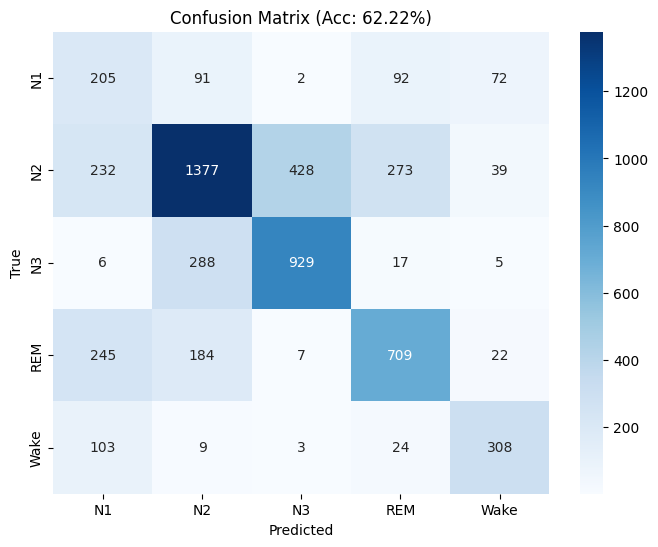

In [16]:
# ----------------------------- Evaluate -----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"\nAccuracy: {acc*100:.2f}%")
print(f"Kappa: {kappa:.4f}")
print(classification_report(y_true, y_pred, target_names=['N1', 'N2', 'N3', 'REM', 'Wake']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'],
            yticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Acc: {acc*100:.2f}%)')
plt.show()